In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import numpy as np
import pandas as pd
df = pd.read_csv('lung cancer survey.csv')
df_no_na = df.dropna()

df_age = df_no_na[df_no_na["AGE"] > 21]
# Use df_age for all models, where clustering algorithm models, such as Kmeans, randomforest, decision tree as they would have already categorise an age threshold within the model
df_age

# Use df_cluster only for logistic regression, lasso, ridge and elastic net - cross comparison of these models with df_age
df_cluster = df_age.copy()
df_cluster['cluster'] = df_cluster['AGE'].apply(lambda x: 1 if x >= 61 else 0)
df_cluster = df_cluster.drop("AGE", axis = 1)
df_cluster

## Cost Complexity Pruning

In [47]:
# Cost complexity pruning, find the best alpha 
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt

X = df_age.drop('LUNG_CANCER', axis=1)  # Drop the target column to get the features
y = df_age['LUNG_CANCER']  # Extract the target column

# Step 1: Split the data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=888
)

# Get a sequence of subtrees
# Define your Decision Tree
model_tree = DecisionTreeClassifier(criterion='entropy', random_state=888)

# Use cost complexity pruning and get sequence of alphas
path = model_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas  # effective alphas of each subtree

# Define the Decision Tree for each alpha
trees = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion = 'entropy', random_state = 888, ccp_alpha = ccp_alpha)
    trees.append(clf)

# Use K-fold cross-validation to choose the best alpha
kf = KFold(n_splits=10, shuffle=True, random_state=888)
mean_cv_errors = []

for clf in trees:
    # Perform cross-validation and get the average error for each alpha
    cv_scores = cross_val_score(clf, X_train, y_train, cv=kf, scoring='f1')
    mean_cv_errors.append(np.mean(cv_scores))  # Get average accuracy for each alpha

# Find the optimal alpha (the one that maximizes the cross-validated accuracy)
optimal_alpha_index = np.argmax(mean_cv_errors)
optimal_alpha = ccp_alphas[optimal_alpha_index]
print(f"Optimal alpha: {optimal_alpha}")

# Prune the tree using the optimal alpha on the training set
pruned_tree = DecisionTreeClassifier(criterion='entropy', random_state=888, ccp_alpha=optimal_alpha)
pruned_tree.fit(X_train, y_train)

# Evaluate the pruned tree on the validation set
y_pred_pruned = pruned_tree.predict(X_val)
print(f"F1-Score with pruning: {f1_score(y_val, y_pred_pruned):.4f}")

Optimal alpha: 0.000805279635025675


DecisionTreeClassifier(ccp_alpha=0.000805279635025675, criterion='entropy',
                       random_state=888)

F1-Score with pruning: 0.9251


In [30]:
# # Visualising post-pruned tree
# plt.figure(figsize=(20, 10))
# plot_tree(pruned_tree,feature_names=X.columns, filled=True)
# plt.title("Decision Tree for Cancer Dataset")
# plt.show()

#Print tree structure as text
tree_rules = export_text(pruned_tree, feature_names=X.columns)
print("Decision Tree Rules:\n", tree_rules)

Decision Tree Rules:
 |--- ALCOHOL CONSUMING <= 0.50
|   |--- YELLOW_FINGERS <= 0.50
|   |   |--- GENDER <= 0.50
|   |   |   |--- WHEEZING <= 0.50
|   |   |   |   |--- ALLERGY  <= 0.50
|   |   |   |   |   |--- FATIGUE  <= 0.50
|   |   |   |   |   |   |--- PEER_PRESSURE <= 0.50
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- PEER_PRESSURE >  0.50
|   |   |   |   |   |   |   |--- SHORTNESS OF BREATH <= 0.50
|   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |--- SHORTNESS OF BREATH >  0.50
|   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |--- FATIGUE  >  0.50
|   |   |   |   |   |   |--- PEER_PRESSURE <= 0.50
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |--- PEER_PRESSURE >  0.50
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- ALLERGY  >  0.50
|   |   |   |   |   |--- class: 1.0
|   |   |   |--- WHEEZING >  0.50
|   |   |   |   |--- ALLERGY  <= 0.50
|   |   |   |   |   |--- SWALLO

## Bagging

Optimal Number of Trees: 86


RandomForestClassifier(criterion='entropy', n_estimators=86, random_state=888)

Corresponding F1 Score: 0.9251


<BarContainer object of 15 artists>

Text(0, 0.5, 'Feature Importance')

Text(0.5, 1.0, 'Feature Importance in Random Forest')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, 'AGE'),
  Text(1, 0, 'YELLOW_FINGERS'),
  Text(2, 0, 'ALCOHOL CONSUMING'),
  Text(3, 0, 'GENDER'),
  Text(4, 0, 'WHEEZING'),
  Text(5, 0, 'SWALLOWING DIFFICULTY'),
  Text(6, 0, 'SMOKING'),
  Text(7, 0, 'ALLERGY '),
  Text(8, 0, 'FATIGUE '),
  Text(9, 0, 'COUGHING'),
  Text(10, 0, 'SHORTNESS OF BREATH'),
  Text(11, 0, 'ANXIETY'),
  Text(12, 0, 'CHRONIC DISEASE'),
  Text(13, 0, 'CHEST PAIN'),
  Text(14, 0, 'PEER_PRESSURE')])

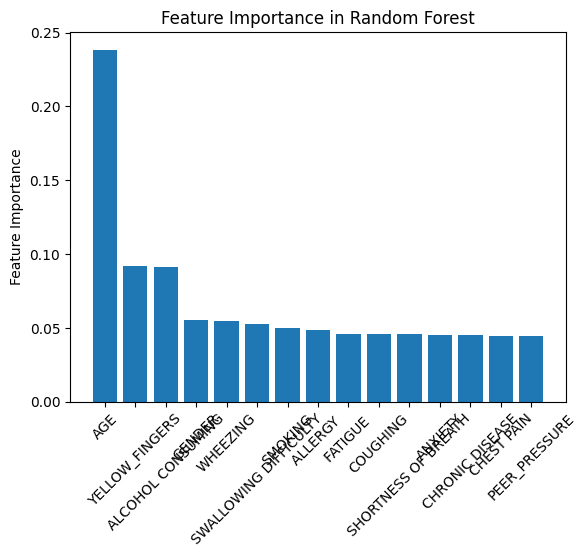

In [45]:
# K-fold + bagging 
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

forests  = []
number_of_trees = range(50, 201)
for i in number_of_trees:
    random_forest = RandomForestClassifier(n_estimators = i, random_state = 888, criterion = "entropy")
    forests.append(random_forest)

kf = KFold(n_splits = 10, shuffle = True, random_state = 888)
mean_cv_errors = []

for rf in forests:
    cv_scores = cross_val_score(rf, X_train, y_train, cv = kf, scoring = 'f1')
    mean_cv_errors.append(np.mean(cv_scores))  

optimal_number_of_trees_index = np.argmax(mean_cv_errors)
optimal_number_of_trees = number_of_trees[optimal_number_of_trees_index]
print(f"Optimal Number of Trees: {optimal_number_of_trees}")

new_forest = RandomForestClassifier(n_estimators = optimal_number_of_trees, random_state = 888, criterion = "entropy")
new_forest.fit(X_train, y_train)
y_pred = new_forest.predict(X_val)

print(f"Corresponding F1 Score: {f1_score(y_pred, y_val):.4f}")

feature_importances = new_forest.feature_importances_
feature_names = df_age.columns.drop(["LUNG_CANCER"])

# Do a reverse sorted vertical bar plot
indices = np.argsort(feature_importances)[::-1]           # [::-1] reverses the order
plt.bar(np.array(feature_names)[indices], feature_importances[indices])
plt.ylabel('Feature Importance')
plt.title('Feature Importance in Random Forest')
plt.xticks(rotation=45)                                   # otherwist xticks is overcrowded with text
plt.show()

In [32]:
# # Basic bagging model
# from sklearn.ensemble import RandomForestClassifier

# X = df_age.drop('LUNG_CANCER', axis=1)  # Drop the target column to get the features
# y = df_age['LUNG_CANCER']  # Extract the target column

# # Step 1: Split the data into training and validation sets (80% training, 20% validation)
# X_train, X_val, y_train, y_val = train_test_split(
#     X, y, test_size=0.2, random_state=888
# )

# # Initialize the model (Note: Bagging is a special case of RF when m = p) & max_features = 1 (by default, meaning all features considered)
# Bagging_classifier = RandomForestClassifier(n_estimators = 100, random_state = 888, criterion = 'entropy',) 

# # Train the model on the training data
# Bagging_classifier.fit(X_train, y_train)

# # Make predictions on the validation data
# y_pred_bagging = Bagging_classifier.predict(X_val)

# # Display the results
# print(f"F1 Score: {f1_score(y_val, y_pred_bagging):.4f}")

RandomForestClassifier(criterion='entropy', random_state=888)

F1 Score: 0.9244


In [35]:
# # With GridSearch
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# X = df_age.drop('LUNG_CANCER', axis=1)  # Drop the target column to get the features
# y = df_age['LUNG_CANCER']  # Extract the target column

# # Step 1: Split the data into training and validation sets (80% training, 20% validation)
# X_train, X_val, y_train, y_val = train_test_split(
#     X, y, test_size=0.2, random_state=888
# )

# # Define the parameter grid for Grid Search
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10]
# }

# # Initialize the Random Forest model
# Bagging_classifier = RandomForestClassifier(random_state=888, criterion='entropy')

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=Bagging_classifier, param_grid=param_grid, 
#                            scoring='f1', cv=5, n_jobs=-1, verbose=2)

# # Train the model on the training data
# grid_search.fit(X_train, y_train)

# # Make predictions on the validation data using the best estimator
# y_pred_bagging = grid_search.best_estimator_.predict(X_val)

# # Display the results
# print(f"Best Parameters: {grid_search.best_params_}")
# print(f"Accuracy: {accuracy_score(y_val, y_pred_bagging):.4f}")
# print(f"Precision: {precision_score(y_val, y_pred_bagging):.4f}")
# print(f"Recall: {recall_score(y_val, y_pred_bagging):.4f}")
# print(f"Bagging F1 Score: {f1_score(y_val, y_pred_bagging):.4f}")

In [37]:
# ? RandomForestClassifier

## Some Codes Jun Hao wanted me to run

In [43]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

# Set seeds for reproducibility
random.seed(888)
tf.random.set_seed(888)
np.random.seed(888)

# Creating the model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(15,)),  # Adjust input shape based on feature count
    tf.keras.layers.Dense(8, activation='sigmoid'),
    tf.keras.layers.Dense(8, activation='sigmoid'),
    tf.keras.layers.Dense(8, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

opt = tf.keras.optimizers.Adam(learning_rate=0.5)
# Compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=2000, batch_size=len(X_train), verbose=0)

# Evaluate model on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
                
# Get predicted probabilities and convert to binary predictions
y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int)
# Calculate precision, recall, and F1-score
precision = precision_score(y_val, y_pred, zero_division=0)
recall = recall_score(y_val, y_pred, zero_division=0)
f1 = f1_score(y_val, y_pred, zero_division=0)

# Display metrics for this iteration
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
Validation Loss: 0.5069, Validation Accuracy: 0.7956
Precision: 0.7956, Recall: 1.0000, F1 Score: 0.8861


In [49]:
# Set seeds for reproducibility
import random
import tensorflow as tf
import numpy as np


random.seed(888)
tf.random.set_seed(888)
np.random.seed(888)

# Creating the model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(15,)),  # Adjust input shape based on feature count
    tf.keras.layers.Dense(8, activation='linear'),
    tf.keras.layers.Dense(23, activation='relu'),
    tf.keras.layers.Dense(8, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

opt = tf.keras.optimizers.Adam(learning_rate=0.026526058661021926)
# Compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=1000, batch_size=len(X_train), verbose=1)

# Evaluate model on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
                
# Get predicted probabilities and convert to binary predictions
y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int)
# Calculate precision, recall, and F1-score
precision = precision_score(y_val, y_pred, zero_division=0)
recall = recall_score(y_val, y_pred, zero_division=0)
f1 = f1_score(y_val, y_pred, zero_division=0)

# Display metrics for this iteration
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.1926 - loss: 0.7220
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8074 - loss: 0.5288
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8074 - loss: 0.4998
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8074 - loss: 0.4932
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8074 - loss: 0.4903
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8074 - loss: 0.4935
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8074 - loss: 0.4913
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8074 - loss: 0.4915
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8074 - loss: 0.4921
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8074 - loss: 0.4926
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8074 - loss: 0.4928
Epoch 12/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8074 -

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step
Validation Loss: 0.5069, Validation Accuracy: 0.7956
Precision: 0.7956, Recall: 1.0000, F1 Score: 0.8861
